In [46]:
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from datetime import datetime
import tensorflow as tf

/var/folders/mb/s55_rmmx4gq6kyms8tszjclh0000gn/T/ipykernel_20006/3878954045.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [59]:
#clean up data for
data = pd.read_csv('full_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

ltc = data.loc[data['Crypto']=='LTC']
ltc = ltc.sort_values(by='Date')
ltc = ltc.drop('Unnamed: 0', axis=1)
ltc = ltc.reset_index(drop=True)
ltc = ltc.drop(['Crypto'],axis=1)
ltc = ltc.set_index('Date')

ltc = ltc.loc[ltc.index<=datetime(2022,5,31)]

In [60]:
def calculate_rsi(prices, window=50):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=50).mean()
    avg_loss = loss.rolling(window=window, min_periods=50).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

def transform_prices(df, window=50):
    df['Returns'] = df['Close'].pct_change()    
    df['MovingAverage'] = df['Close'].rolling(window=50).mean()
    df['Volatility'] = df['Returns'].rolling(window=50).std() * np.sqrt(50)
    df['RSI'] = calculate_rsi(df['Close'])

    # Creating the momentum feature
    df['Momentum'] = df['Close'] - df['MovingAverage']
    df['Momentum'] /= df['MovingAverage'] * df['Volatility']

    # Droping features which the function should not append
    df = df.drop(columns=['MovingAverage'])
    df = df.dropna()

    return df


ltc = transform_prices(ltc)

In [61]:
#function to split X
def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    return X
# Forecasting target t+n days ahead
def ts_split_y(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    y = np.array([ts[idx + feature_steps + target_steps - 1]
                  for idx in range(n_obs)])
    return y

In [62]:
value_features = 50 #we use last 50 days 
value_target = 5 #to forecast 5 days ahead
#split the data for all 3 assets
ltc_open = ts_split(np.array(ltc['Open']), feature_steps = value_features, target_steps = value_target)
ltc_high = ts_split(np.array(ltc['High']), feature_steps = value_features, target_steps = value_target)
ltc_low = ts_split(np.array(ltc['Low']), feature_steps = value_features, target_steps = value_target)
ltc_close = ts_split(np.array(ltc['Close']), feature_steps = value_features, target_steps = value_target)
ltc_ret = ts_split(np.array(ltc['Returns']), feature_steps = value_features, target_steps = value_target)
ltc_vol = ts_split(np.array(ltc['Volatility']), feature_steps = value_features, target_steps = value_target)
ltc_rsi = ts_split(np.array(ltc['RSI']), feature_steps = value_features, target_steps = value_target)
ltc_mom = ts_split(np.array(ltc['Momentum']), feature_steps = value_features, target_steps = value_target)

#Target var of predicting price t+n days ahead
y_ltc = ts_split_y(np.array(ltc['Close']), feature_steps = value_features, target_steps = value_target)

In [63]:
#create the features matrix
combined_array = np.stack((ltc_open, ltc_high , ltc_low, ltc_close, ltc_ret, ltc_vol, ltc_rsi, ltc_mom), axis=1)
X = combined_array

In [64]:
# Determine the size of the validation set
train_idx = round(len(X)*0.8)
X_train_full= X[:train_idx] ## all same for each model

#test data for X and y targets
X_test= X[train_idx:]
y_test_ltc = y_ltc[train_idx:]

val_idx = round(train_idx * 0.1)  # 10% of the training set
train_idx_final = train_idx - val_idx

# Split the training data into training and validation sets
X_train = X_train_full[:train_idx_final]
X_val = X_train_full[train_idx_final:train_idx]

#train and validation for targets
y_train_ltc = y_ltc[:train_idx_final]
y_val_ltc = y_ltc[train_idx_final:train_idx]

#reshape and convert all into pandas series
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_reshaped = pd.DataFrame(X_train_reshaped)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_val_reshaped = pd.DataFrame(X_val_reshaped)

y_train_ltc = pd.DataFrame(y_train_ltc)
y_val_ltc = pd.DataFrame(y_val_ltc)

#reshape  test
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_reshaped = pd.DataFrame(X_test_reshaped)

y_test_ltc_reshaped = y_test_ltc.reshape(y_test_ltc.shape[0], -1)
y_test_ltc_reshaped = pd.DataFrame(y_test_ltc_reshaped)

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.initializers import HeNormal
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
initializer = HeNormal()

# Function to reset the TensorFlow session
def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# Reset the session
    # Reset the session
reset_session()
nuerons = 9
activation = "swish"
l2_reg = 0.00020614917119897043
norm_layer = tf.keras.layers.Normalization(input_shape=X_train_reshaped.shape[1:])
# Define the DNN model
model = Sequential([
    norm_layer,
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(nuerons, activation=activation, kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
    Dense(1)
])
optimizer = Nadam(learning_rate=0.001047217795168058)
model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

# Train the model
history = model.fit(X_train_reshaped, y_train_ltc, epochs=100, validation_data=(X_val_reshaped, y_val_ltc))
y_test_pred = model.predict(X_test_reshaped)
#prediction_accuracy = np.mean(np.sign(pd.DataFrame(y_test_pred).diff().dropna()) == np.sign(pd.DataFrame(y_test_ltc).diff().dropna()))

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 7219.6729 - mse: 7219.5527 - val_loss: 44000.4258 - val_mse: 44000.3047
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7060.4937 - mse: 7060.3750 - val_loss: 42461.5781 - val_mse: 42461.4570
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4850.3599 - mse: 4850.2441 - val_loss: 4633.7778 - val_mse: 4633.6621
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 451.5712 - mse: 451.4565 - val_loss: 4340.5688 - val_mse: 4340.4561
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 383.3949 - mse: 383.2829 - val_loss: 4110.8447 - val_mse: 4110.7344
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 337.4968 - mse: 337.3870 - val_loss: 3914.0381 - val_mse: 3913.9294
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 304.1512 - mse: 304.0434 - val_loss: 3727.8955 - val_mse: 3727.7888
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 275.2715 - mse: 275.1655 - val_loss: 3558.

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step


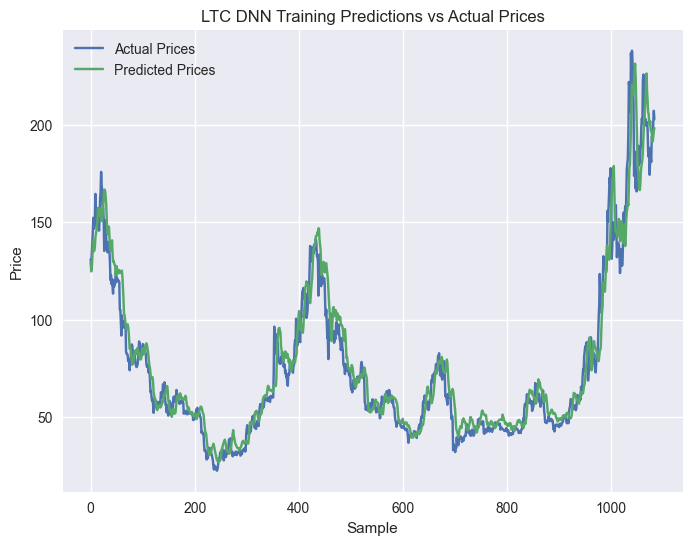

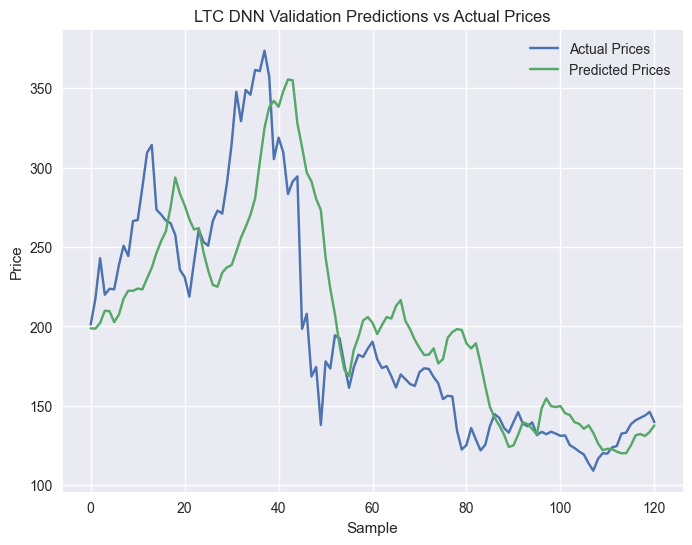

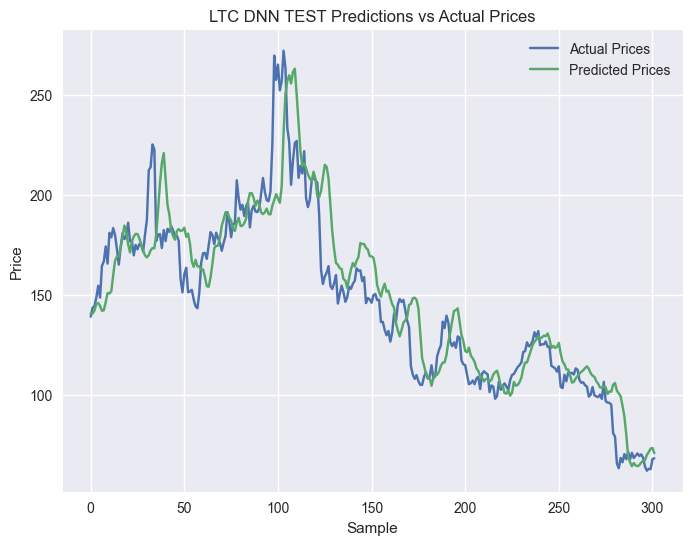

In [69]:
# Make predictions
y_train_pred = model.predict(X_train_reshaped)
y_val_pred = model.predict(X_val_reshaped)
y_test_pred = model.predict(X_test_reshaped)

plt.figure(figsize=(8, 6))
plt.plot(y_train_ltc, label='Actual Prices')
plt.plot(y_train_pred, label='Predicted Prices')
plt.title('LTC DNN Training Predictions vs Actual Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.savefig('final_writeup/Images/ltc_train.png', dpi=200, bbox_inches='tight')

# Plot the predictions vs actual values for validation set
plt.figure(figsize=(8, 6))
plt.plot(y_val_ltc, label='Actual Prices')
plt.plot(y_val_pred, label='Predicted Prices')
plt.title('LTC DNN Validation Predictions vs Actual Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.savefig('final_writeup/Images/ltc_validation.png', dpi=200, bbox_inches='tight')

# Plot the predictions vs actual values for validation set
plt.figure(figsize=(8, 6))
plt.plot(y_test_ltc, label='Actual Prices')
plt.plot(y_test_pred, label='Predicted Prices')
plt.title('LTC DNN TEST Predictions vs Actual Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.savefig('final_writeup/Images/ltc_test.png', dpi=200, bbox_inches='tight')
plt.show()

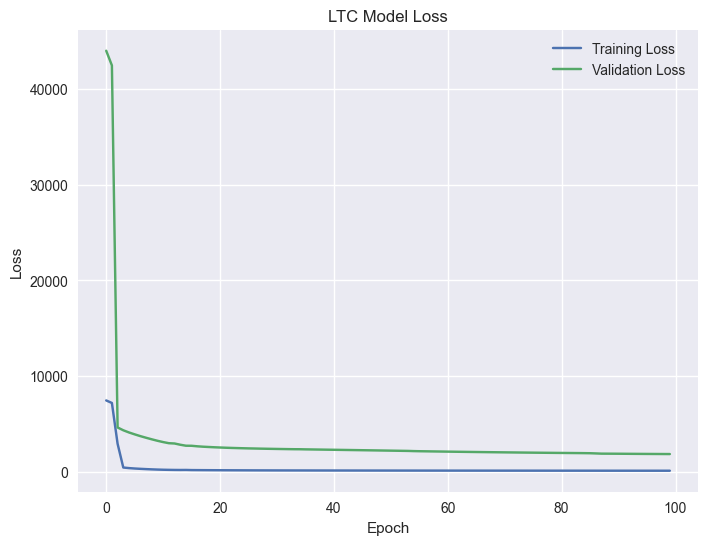

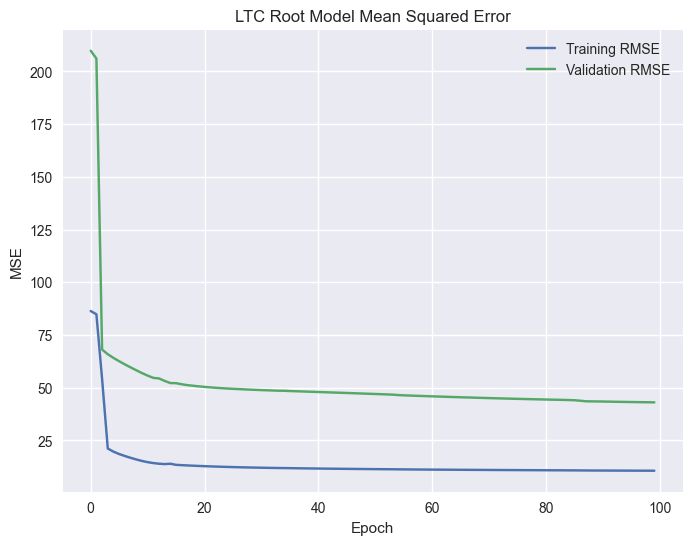

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LTC Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('final_writeup/Images/ltc_model_loss.png', dpi=200, bbox_inches='tight')

# Plot training & validation MSE values
plt.figure(figsize=(8, 6))
plt.plot(np.sqrt(history.history['mse']), label='Training RMSE')
plt.plot(np.sqrt(history.history['val_mse']), label='Validation RMSE')
plt.title('LTC Root Model Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.savefig('final_writeup/Images/ltc_rmse.png', dpi=200, bbox_inches='tight')
plt.show()

In [71]:
model.save("ltc_model_final.keras")

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Nadam
import keras_tuner as kt
import tensorflow as tf

def reset_session(seed=42):
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=10, max_value=50, default=2)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=100)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    l2_reg = hp.Float("l2_reg", min_value=1e-4, max_value=100, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "Nadam", "Adam"])
    activation = hp.Choice("activation", values=["relu", "swish"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.0)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_train_scaled.shape[1:]))
    model.add(tf.keras.layers.Normalization())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss="mse", optimizer=optimizer,
                  metrics=["RootMeanSquaredError"])
    return model

In [16]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_loss", max_trials=50, overwrite=True,
    directory="LTC", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train_scaled, y_train_ltc, epochs=50,
                           validation_data=(X_val_scaled, y_val_ltc))

Trial 50 Complete [00h 00m 13s]
val_loss: 5865.2783203125

Best val_loss So Far: 2521.851806640625
Total elapsed time: 00h 11m 17s


In [17]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
best_params = top3_params[0].values

print(f"Best hyperparameters: {best_params}")

/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 131 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 199 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'n_hidden': 31, 'n_neurons': 9, 'learning_rate': 0.001047217795168058, 'l2_reg': 0.00020614917119897043, 'optimizer': 'Adam', 'activation': 'swish'}


/opt/homebrew/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 95 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
